In [1]:
import requests

In [2]:
# Downloading tesseract-ocr file
r = requests.get("https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/ind.traineddata", stream = True)

# Writing data to file to avoid path isuues
with open("/usr/share/tesseract-ocr/4.00/tessdata/ind.traineddata", "wb") as file:
    for block in r.iter_content(chunk_size = 1024):
         if block:
             file.write(block)

In [3]:
# Installing libraries required for optical character recognition
! apt install tesseract-ocr libtesseract-dev libmagickwand-dev

# Importing IPython to clear output which is not important
from IPython.display import HTML, clear_output
clear_output()

In [4]:
# Installing pytesseract and opencv
! pip install pytesseract wand opencv-python
clear_output()

In [5]:
# Import libraries
from PIL import Image
import pytesseract
import cv2
import numpy as np
from pytesseract import Output
import re

In [46]:
image = Image.open(requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQMWKTzNNcdDKcJfYPe8ieu7eNiSBl14TA7rA&usqp=CAU',stream = True).raw)

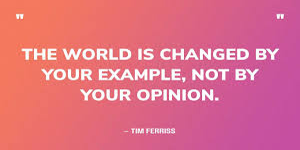

In [47]:
image = image.resize((300,150))
image.save('sample.png')
image


In [48]:
custom = r'-l eng --oem 3 --psm 6'
text = pytesseract.image_to_string(image,config=custom)
text

'THE WORLD IS CHANGED BY\nYOUR EXAMPLE, NOT BY\n‘YOUR OPINION.\n\x0c'

In [49]:
# Extracting text from image and removing irrelevant symbols from characters
try:
  text=pytesseract.image_to_string(image,lang="eng")
  characters_to_remove = "!()@—*“>+-/,'|£#%$&^_~"
  new_string = text
  for character in characters_to_remove:
    new_string = new_string.replace(character, "")
  print(new_string)
except IOError as e:
    print("Error (%s)." % e)

THE WORLD IS CHANGED BY
YOUR EXAMPLE NOT BY
‘YOUR OPINION.



In [50]:
image = cv2.imread('sample.png')

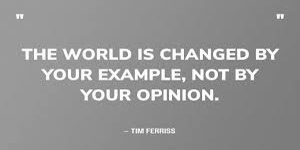

In [51]:
def greyScale(image):
  return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
gray = greyScale(image)
Image.fromarray(gray)

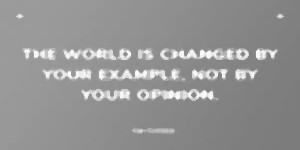

In [52]:
def noiseRedux(image):
  return cv2.medianBlur(image,5)
noise= noiseRedux(gray)
Image.fromarray(noise)

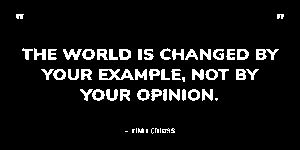

In [53]:
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = thresholding(gray)
Image.fromarray(thresh)

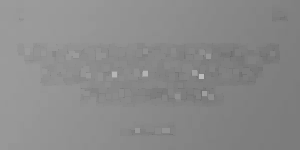

In [54]:
#Morphology
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
opening = opening(gray)
Image.fromarray(opening)

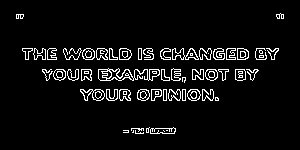

In [55]:
#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)
canny = canny(gray)
Image.fromarray(canny)

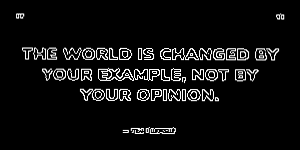

In [56]:
#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated
rotated = deskew(canny)
Image.fromarray(rotated)

In [57]:
#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
match = match_template(gray, gray)
match

array([[1.]], dtype=float32)

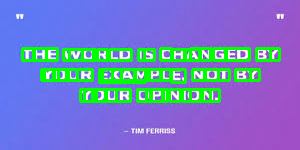

In [58]:
img = cv2.imread('sample.png')
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
Image.fromarray(img)

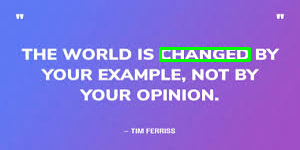

In [60]:
# Drawing pattern on specific pattern or word
img = cv2.imread('sample.png')
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

date_pattern = 'CHANGED'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
    	if re.match(date_pattern, d['text'][i]):
	        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
	        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
Image.fromarray(img)